# Working with the hourly Global Drifter Program (GDP) data

In this Notebook, we use the [hourly data](https://www.aoml.noaa.gov/phod/gdp/hourly_data.php) from the [NOAA Global Drifter Program](https://www.aoml.noaa.gov/global-drifter-program/) to illustrate the steps to preprocess a Lagrangian dataset into a `RaggedArray` format that can be then emitted as `xarray.Dataset` or `awkward.Array` instances.

## Import the `RaggedArray` class

In [1]:
from clouddrift import RaggedArray

The `RaggedArray` class can be initialized with a series of `dict`s matching the name of the variables of the original data with the ragged representation of the data and their respectives attributes.

In [2]:
help(RaggedArray)

Help on class RaggedArray in module clouddrift.dataformat:

class RaggedArray(builtins.object)
 |  RaggedArray(coords: dict, metadata: dict, data: dict, attrs_global: Optional[dict] = {}, attrs_variables: Optional[dict] = {})
 |  
 |  Methods defined here:
 |  
 |  __init__(self, coords: dict, metadata: dict, data: dict, attrs_global: Optional[dict] = {}, attrs_variables: Optional[dict] = {})
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  to_awkward(self)
 |      Convert ragged array object to an Awkward Array.
 |      
 |      Returns:
 |          ak.Array: Awkward Array containing the ragged arrays and their attributes
 |  
 |  to_netcdf(self, filename: str)
 |      Export ragged array object to a NetCDF archive.
 |      
 |      Args:
 |          filename (str): filename of the NetCDF archive of ragged arrays
 |  
 |  to_parquet(self, filename: str)
 |      Export ragged array object to a parquet archive.
 |      
 |      Args:
 |          filename (

The length of the variables in the dataset is either equal to the number of trajectories (`nb_traj`) or the number of observations (`obs`) derived along the trajectories. 

The first three dictionnaries, `coords`, `metadata`, and `data`, match the variable names for coordinates variables, metatadata variables, and data variables, respectively, with the ragged representation of the data.

- The coordinates are mandatory variables (length `obs`) for the ragged array to be used with the library and are always `time`, `lon`, `lat`, and `ids`. 
- The metadata variables (length `nb_traj`) are constant values associated with a single trajectory such as the length of the observations (`rowsize`), the deployment information (`deploy_lon`, `deploy_lat`, `deploy_date`), the type of buoys (`typebuoy`), etc.
- The data variables (length `obs`) are quantity derived along the trajectories such as velocity component (`ve`, `vn`), the sea surface temperature and its uncertainty (`sst`, `err_sst`), the drogue presence flag (`drogue_status`), etc.

The last two dictionaries, `attrs_global` and `attrs_variables`, are optional and contain the attributes related to the dataset and each variable, respectively.

## The `RaggedArray.from_files()` method

This method is available to initialize a `RaggedArray` instance from a series of files.

In [3]:
help(RaggedArray.from_files)

Help on method from_files in module clouddrift.dataformat:

from_files(indices: list, preprocess_func: collections.abc.Callable[[int], xarray.core.dataset.Dataset], vars_coords: dict, vars_meta: list = [], vars_data: list = [], rowsize_func: Optional[collections.abc.Callable[[int], int]] = None) method of builtins.type instance
    Generate ragged arrays archive from a list of trajectory files
    
    Args:
        indices (list): identification numbers list to iterate
        preprocess_func (Callable[[int], xr.Dataset]): returns a processed xarray Dataset from an identification number
        vars_coords (dict): Dictionary mapping field dimensions (ids, time, lon, lat)
        vars_meta (list, optional): metadata variable names to include in the archive (Defaults to [])
        vars_data (list, optional): data variable names to include in the archive (Defaults to [])
        rowsize_func (Optional[Callable[[int], int]], optional): returns a processed xarray Dataset from an identific

This method was inspired by the [Pangeo Forge](https://pangeo-forge.readthedocs.io/en/latest/) project which aims at easing the extraction of data from traditional data archives and deposition in cloud object storage. For our `RaggedArray.from_files()` method, the different parameters are:

- `indices`: a list of indices (or identification numbers) that will be iterated over to concatenate the files into the `RaggedArray` instance;
- `preprocess_func`: A preprocessing function with the following signature:
    - `Signature: preprocess_func(index: int) -> xarray.core.dataset.Dataset`, where the index parameter is an identifier of a trajectory, e.g. the identification number of an Argo float) and returns an [xarray Dataset](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.html). 
- `vars_coords`: a dictionary mapping the mandatory coordinates list to the name of those variables in the dataset, e.g.
    `coords = {'ids': 'number', 'time': 't', 'lon': 'longitude', 'lat': 'latitude'}`
- `vars_meta`: an optional list of variable names containing metadata information about the trajectory (size: 1 per trajectory)
- `vars_data`: an optional list of variable names containing the data along the trajectory (size: number of observations per trajectory)
- `rowsize_func`: an optional function that returns directly the number of observation of a trajectory (`Signature: rowsize_func(index: int) -> int`)

Because every dataset is unique, the preprocessing function is used to perform operations such as: formatting the date and time, changing the type of the variables, modifying the metadata, and similar. The class also needs to initially calculate the sum of all observations to allocate memory. To speed up this process where a lot of preprocessing is needed, it is possible to provide a second function `rowsize_func`, that returns directly the number of observations of a trajectory (`Signature: rowsize_func(index: int) -> int`). By default, this operation is performed using `lambda i: preprocess_func(i).dims['obs']`. 

We provide preprocessing function for different datasets in the `data/` folder (`gdp.py`, `gdp6h.py`, `parcels.py`, etc.) and those can serve as a guide to defined a new set of functions for another dataset.

# Dataset-specific functions
The `gdp.py` module contains a number of specific functions for the current GDP files, including:
- `gdp.preprocess`: applies preprocessing routine and returned a `xarray.Dataset` for a specific trajectory 
- `gdp.download`: fetches NetCDF files from the GDP FTP server
- `gdp.rowsize [Optional]`: returns the dimension of a specific trajectory to speed up the preprocessing

In [4]:
import sys
sys.path.append('../')
from data import gdp

## Download the GDP data

The `gdp.download` function will store the raw dataset into the `data/raw/gdp-v2.00/` folder (specified in the `gdp.py` module). By default `download()` will download the complete GPD dataset (containing 17,324 files for versions 1.04c and 2.00) from the AOML repository ([link](https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/hourly/v2.00/netcdf/)).

In [5]:
help(gdp.download)

Help on function download in module data.gdp:

download(drifter_ids: list = None, n_random_id: int = None)
    Download individual NetCDF files from the AOML server
    
    :param drifter_ids [list]: list of drifter to retrieve (Default: all)
    :param n_random_id [int]: randomly select n drifter NetCDF files
    :return drifters_ids [list]: list of retrived drifter



With this function, it is also possible to retrieve a subset from a `drifter_ids` list or specified an integer `n_random_id` to randomly retrieve `n` trajectories. If both arguments are given, the function downloads `n_random_id` out of the list `drifter_ids`. The function returns the list of `drifters_ids` that was downloaded, and can be passed to create the ragged array.

In [6]:
drifter_ids = gdp.download(n_random_id=100)

In [7]:
drifter_ids[:5]

array([9706570,    6428,   17927,   30460,   22406])

## Create the `RaggedArray` instance

Once the data are downloaded, the *RaggedArray* object can be created and archived as a NetCDF file or a parquet file. In addition, the ragged array can be converted to an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) or an [Awkward Array](https://awkward-array.readthedocs.io/en/stable/_auto/ak.Array.html) in order to conduct analyses.

Before we do that, we must first define the dataset-specific coordinates, data, and metadata information.

In [8]:
coords = {
    'ids': 'ids',
    'time': 'time',
    'lon': 'longitude', # or alternatively lon360
    'lat': 'latitude'
}
metadata = [
    'ID',
    'rowsize', 
    'WMO',
    'expno',
    'deploy_date',
    'deploy_lat',
    'deploy_lon',
    'end_date',
    'end_lat',
    'end_lon',
    'drogue_lost_date',
    'typedeath',
    'typebuoy',
    'location_type',
    'DeployingShip',
    'DeploymentStatus',
    'BuoyTypeManufacturer',
    'BuoyTypeSensorArray',
    'CurrentProgram',
    'PurchaserFunding',
    'SensorUpgrade',
    'Transmissions',
    'DeployingCountry',
    'DeploymentComments',
    'ManufactureYear',
    'ManufactureMonth',
    'ManufactureSensorType',
    'ManufactureVoltage',
    'FloatDiameter',
    'SubsfcFloatPresence',
    'DrogueType',
    'DrogueLength',
    'DrogueBallast',
    'DragAreaAboveDrogue',
    'DragAreaOfDrogue',
    'DragAreaRatio',
    'DrogueCenterDepth',
    'DrogueDetectSensor'
]
data = [
    've',
    'vn',
    'err_lat',
    'err_lon',
    'err_ve',
    'err_vn',
    'gap',
    'sst',
    'sst1',
    'sst2',
    'err_sst',
    'err_sst1',
    'err_sst2',
    'flg_sst',
    'flg_sst1',
    'flg_sst2',
    'drogue_status'
]

In [9]:
ra = RaggedArray.from_files(
    drifter_ids,
    gdp.preprocess,
    coords, 
    metadata,
    data,
    rowsize_func=gdp.rowsize
)

Retrieving the number of obs: 100%|██████████| 100/100 [00:00<00:00, 112.35it/s]
/Users/pmiron/micromamba/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
Filling the Ragged Array: 100%|███████████████| 100/100 [00:03<00:00, 31.32it/s]


## Export to data files

Currently, the library supports exporting the `RaggedArray` instance to NetCDF and Apache Parquet file formats.

### NetCDF

In [10]:
ra.to_netcdf('../data/process/gdp_v2.00.nc')

### Apache Parquet

In [11]:
ra.to_parquet('../data/process/gdp_v2.00.parquet')

## Import from data files

As with exporting to files, we can import a `RaggedArray` instance from a NetCDF or Apache Parquet files. 

### NetCDF

In [12]:
ra = RaggedArray.from_netcdf('../data/process/gdp_v2.00.nc')

### Apache Parquet

In [13]:
ra = RaggedArray.from_parquet('../data/process/gdp_v2.00.parquet')

## Converting to data structures for analysis

Typically, you would not do your data analysis directly on a `RaggedArray` instance.
Instead, you first convert it to a data structure that is geared for data analysis and exploratory science.
Currently, the library supports Xarray Dataset and Awkward Array structures.

### Xarray Dataset

In [14]:
ds = ra.to_xarray()

Now we have our GDP dataset as an Xarray Dataset while also being optimized for memory.
Let's see what's inside:

In [15]:
ds

<xarray.Dataset>
Dimensions:                (traj: 100, obs: 939619)
Coordinates:
    time                   (obs) float64 9.061e+08 9.061e+08 ... 1.586e+09
    lon                    (obs) float32 -18.42 -18.43 -18.44 ... -142.6 -142.6
    lat                    (obs) float32 44.99 44.99 44.99 ... -4.311 -4.315
    ids                    (obs) int64 9706570 9706570 ... 67772920 67772920
Dimensions without coordinates: traj, obs
Data variables: (12/55)
    ID                     (traj) int64 9706570 6428 17927 ... 68246720 67772920
    rowsize                (traj) int32 5766 19132 17906 86 ... 2836 1843 221
    WMO                    (traj) int32 6200519 1600536 ... 4601712 5102772
    expno                  (traj) int32 9435 9435 9435 ... 21312 21312 21312
    deploy_date            (traj) float32 9.061e+08 9.792e+08 ... nan 1.585e+09
    deploy_lat             (traj) float64 45.0 -48.19 -47.04 ... 24.27 -3.0
    ...                     ...
    err_sst1               (obs) float64 nan nan nan nan ... 0.004 0.005 0.006
    err_sst2               (obs) float64 nan nan nan nan ... 0.01 0.012 0.016
    flg_sst                (obs) int8 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5
    flg_sst1               (obs) int8 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5
    flg_sst2               (obs) int8 0 0 0 0 0 0 0 0 0 0 ... 5 5 5 5 5 5 5 5 5
    drogue_status          (obs) bool True True True True ... True True True
Attributes: (12/16)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00. Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2023-01-17T21:05:19.020340
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    summary:           Global Drifter Program hourly data
    doi:               10.25921/x46c-3620


Time, longitude, and latitude arrays are 1-dimensional and are effectively a concatenated list of drifter trajectories. The `ids` array can be used to mask (subset) a specific drifter. Let's make a trajectory map by looping over all the trajectories and plotting them one by one.

In [16]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '100 random trajectories from the hourly GDP dataset')

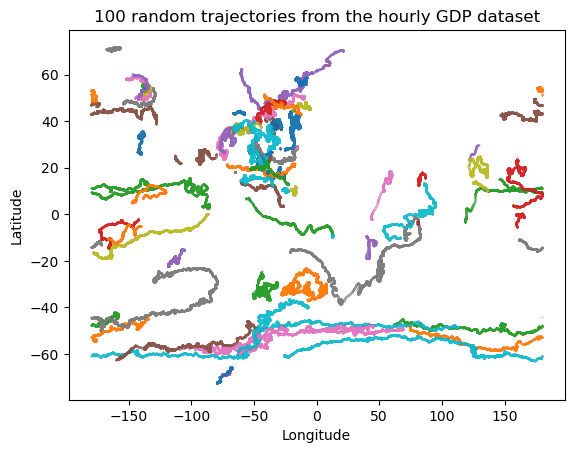

In [17]:
for drifter_id in drifter_ids:
    this_drifter = ds.ids == drifter_id
    plt.plot(ds.lon[this_drifter], ds.lat[this_drifter], linestyle='', marker='.', ms=0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('100 random trajectories from the hourly GDP dataset')

You may find that the method above is relatively slow to plot for a large number of trajectories. Alternatively, we can construct an index variable that indexes the beginning of each trajectory in the ragged arrays (with index `0` for the first trajectory). We first need to import the `numpy` package to conduct some mathematical operations to calculate that index variable.

In [18]:
import numpy as np

In [19]:
traj_idx = np.insert(np.cumsum(ds.rowsize.values),0,0)

Text(0.5, 1.0, '100 random trajectories from the hourly GDP dataset')

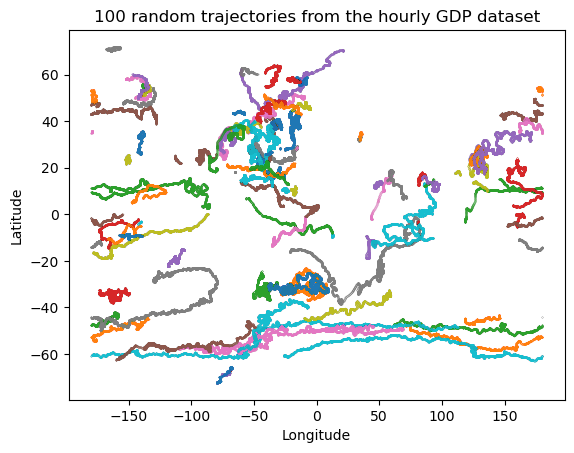

In [20]:
for j in range(len(drifter_ids)):
    plt.plot(ds.lon[slice(traj_idx[j],traj_idx[j+1])], ds.lat[slice(traj_idx[j],traj_idx[j+1])], linestyle='', marker='.', ms=0.1)    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('100 random trajectories from the hourly GDP dataset')

### Awkward Array

In [21]:
ds = ra.to_awkward()

With an awkward array, there is no need to define an index variable as for an xarray Dataset:

Text(0.5, 1.0, '100 random trajectories from the hourly GDP dataset')

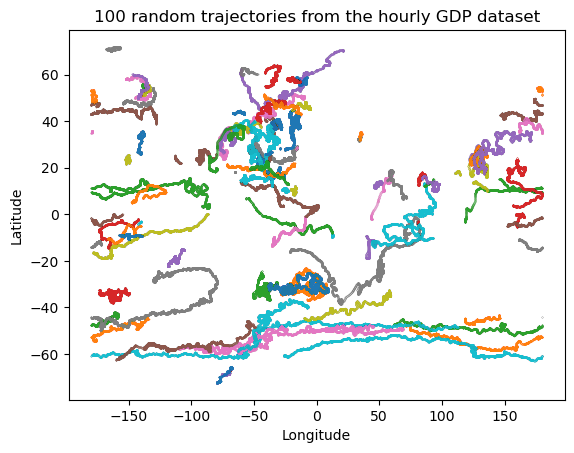

In [22]:
for n in range(len(drifter_ids)):
    plt.plot(ds.obs['lon'][n], ds.obs['lat'][n], linestyle='', marker='.', ms=0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('100 random trajectories from the hourly GDP dataset')